In [1]:
import os
import pickle
from torchvision import transforms
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2
import random
from tqdm import tqdm
import json

from skimage.transform import resize
from shapely.geometry import box, Polygon

%load_ext autoreload
%autoreload 2

/home/jmorales/miniconda3/envs/stvqa_rl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load data

In [2]:
data_dir = "/data/users/jmorales/svhn/"

# Load splits data
with open(data_dir + "train_data.pkl", "rb") as f:
    train_data = pickle.load(f)
with open(data_dir + "val_data.pkl", "rb") as f:
    val_data = pickle.load(f)
with open(data_dir + "test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

In [4]:
all_data = train_data + val_data + test_data
print("Size before filtering:", len(all_data))

# filter data with numberes with up to N digits
N = 2
all_data = [i for i in all_data if len(i["boxes"]) <= N]
print("Size after filtering:", len(all_data))

Size before filtering: 248540
Size after filtering: 115140


In [127]:
dataset_length = 500000

dataset = []

for i in tqdm(range(dataset_length)):
    # Get a random number from the dataset
    sample1 = random.sample(all_data, 1)[0]
    sample2 = random.sample(all_data, 1)[0]
    
    """while True:
        # randomly sample a second number
        sample2 = random.sample(all_data, 1)[0]
        
        # ensure that the second number doesn't start with the same digit as the first one.
        if sample1["boxes"][0]["label"] != sample2["boxes"][0]["label"]:
            break"""
        
    dataset.append((sample1, sample2))

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [00:03<00:00, 127221.55it/s]


In [128]:
# Ensure reproducibility
random.seed(0)

total_length = len(dataset)
print("Total dataset length:", total_length)

# not necessary, but whatever
shuffle_data = random.sample(dataset, total_length)

train_length = int(0.8*total_length)
val_length = int(0.1*total_length)

train_data = shuffle_data[:train_length]
val_data = shuffle_data[train_length:train_length+val_length]
test_data = shuffle_data[train_length+val_length:]

print("Training set length:", len(train_data))
print("Val set length:", len(val_data))
print("Test set length:", len(test_data))

Total dataset length: 500000
Training set length: 400000
Val set length: 50000
Test set length: 50000


In [129]:
# Create dataset
def create_split(raw_data, split, save_dir, img_size=224, bbox_size=64, num_numbers=2):
    assert split in ["train", "val", "test"], "Split must be 'train', 'val' or 'test'"
    
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
    img_folder = os.path.join(save_dir, split)
    if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    
    split_data = []    
    for i, numbers in tqdm(enumerate(raw_data), desc="Creating dataset:", total=len(raw_data)):
        current_sample = {
            "id": i,
            "numbers": []
            }
        
        
        # Initialize backgroud image
        new_img = np.zeros((img_size, img_size), dtype="uint8")

        # to blur borders, we create a mask around the bbox to do inpainting
        mask = np.ones(new_img.shape, dtype="uint8")
        
        # we need to keep track of where the numbers are placed to decide its order
        numbers_positions = []

        # POlygon object to keep track of numbers and avoid overlaping bboxes
        locs_union = Polygon()

        for number in numbers:            
            # open image
            img_path = os.path.join(data_dir, number["dataset_split"], number["filename"])
            img = Image.open(img_path).convert('L')
            
            # get digit bboxes
            bboxes = number["boxes"]
            
            current_sample["numbers"].append([digit["label"] for digit in bboxes])

            # Get smaller bounding box that contain all digit bounding boxes
            x1 = int(min([i["left"] for i in bboxes]))
            y1 = int(min([i["top"] for i in bboxes]))
            x2 = int(max([i["left"] + i["width"] for i in bboxes]))
            y2 = int(max([i["top"] + i["height"] for i in bboxes]))
            
            # get matrix containing the bbox
            bbox_img = np.array(img)[y1:y2, x1:x2]
            bbox_img = (resize(bbox_img, (bbox_size, bbox_size)) * 256).astype("uint8")
            
            """# compute the mean background color and create an empty background image with random noise
            mean_background_color = np.median(
                np.concatenate([bbox_img[:, 0], bbox_img[:, -1], bbox_img[0, :], bbox_img[-1, :]]))
            
            
            # invert colors if background dark
            if mean_background_color < 0.5*255:
                bbox_img = 255 - bbox_img
                mean_background_color = 255 - mean_background_color"""
            
            # randomly paste the bbox on the background image.
            # first, find 
            border = 10
            while True:
                # candidate position
                rand_x, rand_y = np.random.randint(0, img_size-bbox_size), np.random.randint(0, img_size-bbox_size)
                
                # test if the current position doesnt intersect with previous numbers
                poly_bbox = box(rand_x-border, rand_y-border, rand_x+bbox_size+border, rand_y+bbox_size+border)
                if poly_bbox.intersection(locs_union).area == 0:
                    # if there is no intersection, the position is valid
                    locs_union = locs_union.union(poly_bbox)
                    break
                
            new_img[rand_y:rand_y+bbox_size, rand_x:rand_x+bbox_size] = bbox_img
            
            # save bbox position for the current number
            numbers_positions.append(((rand_x, rand_y), (rand_x+BBOX_SIZE, rand_y+BBOX_SIZE)))
            
            # update inpainting mask
            mask[rand_y:rand_y+bbox_size, rand_x:rand_x+bbox_size] = 0
            
        new_img = cv2.inpaint(new_img, mask, 32, cv2.INPAINT_TELEA)

        # convert to PIL and save
        img = Image.fromarray(new_img[:, :, None].repeat(3, 2))
        img.save(os.path.join(img_folder, f"{current_sample['id']}.png"))
        
        
        # Decide label order
        # if both numbers have similar height...
        p1, p2 = numbers_positions[0], numbers_positions[1]
        if abs(p1[0][1] - p2[0][1]) < BBOX_SIZE:
            # the one more to the left is the first
            if p1[0][0] < p2[0][0]:
                current_sample["first"] = current_sample["numbers"][0]
                current_sample["second"] = current_sample["numbers"][1]
            else:
                current_sample["second"] = current_sample["numbers"][0]
                current_sample["first"] = current_sample["numbers"][1]
        else:
            if p1[0][1] < p2[0][1]:
                current_sample["first"] = current_sample["numbers"][0]
                current_sample["second"] = current_sample["numbers"][1]
            else:
                current_sample["second"] = current_sample["numbers"][0]
                current_sample["first"] = current_sample["numbers"][1]
        
        current_sample.pop("numbers")
        split_data.append(current_sample)
    
    # save split data
    with open(os.path.join(save_dir, f"{split}_split.json"), "w") as f:
        json.dump(split_data, f)


In [130]:
def create_sample(input):# i, numbers in tqdm(enumerate(raw_data), desc="Creating dataset:", total=len(raw_data)):
        id, numbers, img_folder = input
        current_sample = {
            "id": id,
            "numbers": []
            }
        
        # Data config
        img_size = 224
        bbox_size = 64
        
        # Initialize backgroud image
        new_img = np.zeros((img_size, img_size), dtype="uint8")

        # to blur borders, we create a mask around the bbox to do inpainting
        mask = np.ones(new_img.shape, dtype="uint8")
        
        # we need to keep track of where the numbers are placed to decide its order
        numbers_positions = []

        # POlygon object to keep track of numbers and avoid overlaping bboxes
        locs_union = Polygon()

        for number in numbers:            
            # open image
            img_path = os.path.join(data_dir, number["dataset_split"], number["filename"])
            img = Image.open(img_path).convert('L')
            
            # get digit bboxes
            bboxes = number["boxes"]
            
            current_sample["numbers"].append([digit["label"] for digit in bboxes])

            # Get smaller bounding box that contain all digit bounding boxes
            x1 = int(min([i["left"] for i in bboxes]))
            y1 = int(min([i["top"] for i in bboxes]))
            x2 = int(max([i["left"] + i["width"] for i in bboxes]))
            y2 = int(max([i["top"] + i["height"] for i in bboxes]))
            
            # get matrix containing the bbox
            bbox_img = np.array(img)[y1:y2, x1:x2]
            bbox_img = (resize(bbox_img, (bbox_size, bbox_size)) * 256).astype("uint8")
            
            """# compute the mean background color and create an empty background image with random noise
            mean_background_color = np.median(
                np.concatenate([bbox_img[:, 0], bbox_img[:, -1], bbox_img[0, :], bbox_img[-1, :]]))
            
            
            # invert colors if background dark
            if mean_background_color < 0.5*255:
                bbox_img = 255 - bbox_img
                mean_background_color = 255 - mean_background_color"""
            
            # randomly paste the bbox on the background image.
            # first, find 
            border = 10
            while True:
                # candidate position
                rand_x, rand_y = np.random.randint(0, img_size-bbox_size), np.random.randint(0, img_size-bbox_size)
                
                # test if the current position doesnt intersect with previous numbers
                poly_bbox = box(rand_x-border, rand_y-border, rand_x+bbox_size+border, rand_y+bbox_size+border)
                if poly_bbox.intersection(locs_union).area == 0:
                    # if there is no intersection, the position is valid
                    locs_union = locs_union.union(poly_bbox)
                    break
                
            new_img[rand_y:rand_y+bbox_size, rand_x:rand_x+bbox_size] = bbox_img
            
            # save bbox position for the current number
            numbers_positions.append(((rand_x, rand_y), (rand_x+BBOX_SIZE, rand_y+BBOX_SIZE)))
            
            # update inpainting mask
            mask[rand_y:rand_y+bbox_size, rand_x:rand_x+bbox_size] = 0
            
        new_img = cv2.inpaint(new_img, mask, 32, cv2.INPAINT_TELEA)

        # convert to PIL and save
        img = Image.fromarray(new_img[:, :, None].repeat(3, 2))
        img.save(os.path.join(img_folder, f"{current_sample['id']}.png"))
        
        
        # Decide label order
        # if both numbers have similar height...
        p1, p2 = numbers_positions[0], numbers_positions[1]
        if abs(p1[0][1] - p2[0][1]) < BBOX_SIZE:
            # the one more to the left is the first
            if p1[0][0] < p2[0][0]:
                current_sample["first"] = current_sample["numbers"][0]
                current_sample["second"] = current_sample["numbers"][1]
            else:
                current_sample["second"] = current_sample["numbers"][0]
                current_sample["first"] = current_sample["numbers"][1]
        else:
            if p1[0][1] < p2[0][1]:
                current_sample["first"] = current_sample["numbers"][0]
                current_sample["second"] = current_sample["numbers"][1]
            else:
                current_sample["second"] = current_sample["numbers"][0]
                current_sample["first"] = current_sample["numbers"][1]
        
        current_sample.pop("numbers")
        return current_sample
        
# Create dataset
def create_split(raw_data, split, save_dir, num_workers=8):
    assert split in ["train", "val", "test"], "Split must be 'train', 'val' or 'test'"
    
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
    img_folder = os.path.join(save_dir, split)
    if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    from multiprocessing import Pool
    #pool = Pool(num_workers)                         # Create a multiprocessing Pool
    #split_data = pool.map(create_sample, [(i, data, img_folder) for i, data in enumerate(raw_data)])  # process data_inputs iterable with pool
    pool_input = [(i, data, img_folder) for i, data in enumerate(raw_data)]
    with Pool(num_workers) as pool:
      split_data = list(tqdm(pool.imap(create_sample, pool_input), total=len(pool_input)))
    
    # save split data
    with open(os.path.join(save_dir, f"{split}_split.json"), "w") as f:
        json.dump(split_data, f)


In [134]:
create_split(train_data, split="train", save_dir="/data/users/jmorales/svhn_multi_number", num_workers=36)

  2%|▏         | 7360/400000 [08:40<7:43:07, 14.13it/s] 


KeyboardInterrupt: 

In [ ]:
create_split(test_data, split="test", save_dir="/data/users/jmorales/svhn_multi_number", num_workers=12)

In [ ]:
create_split(val_data, split="val", save_dir="/data/users/jmorales/svhn_multi_number", num_workers=12)

In [ ]:
# Visualize dataset

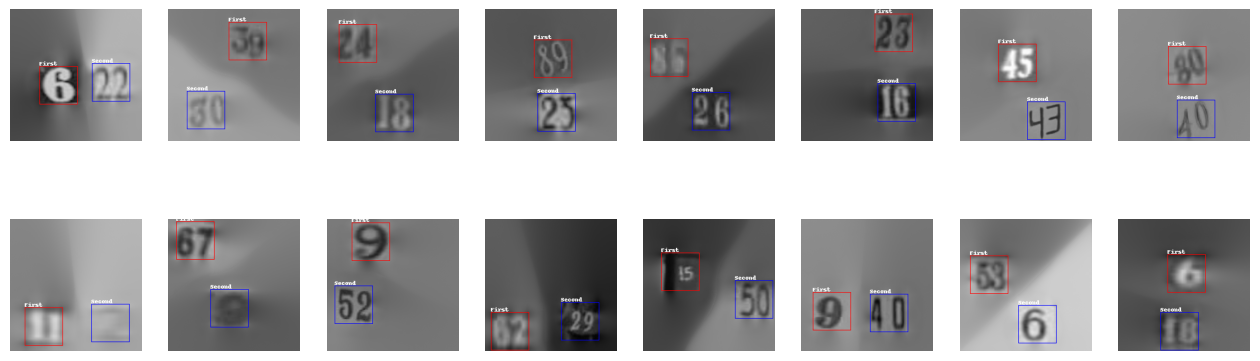

In [10]:
ncols, nrows = 8, 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 5))


IMG_SIZE = 224
BBOX_SIZE = 64
NUM_NUMBERS = 2

rand_idx = np.random.randint(low=0, high=len(all_data), size=(NUM_NUMBERS, nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        # Initialize backgroud image
        new_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype="uint8")
        
        # to blur borders, we create a mask around the bbox to do inpainting
        mask = np.ones(new_img.shape, dtype="uint8")
        
        # POlygon object to keep track of numbers and avoid overlaping bboxes
        locs_union = Polygon()
        
        numb_bboxes = []
        
        for k in range(NUM_NUMBERS):
            # get random sample
            sample = all_data[rand_idx[k, i, j]]
            
            # open image
            img_path = os.path.join(data_dir, sample["dataset_split"], sample["filename"])
            img = Image.open(img_path).convert('L')
            #w, h = img.size
            
            # get digit bboxes
            bboxes = sample["boxes"]

            # Get smaller bounding box that contain all digit bounding boxes
            x1 = int(min([i["left"] for i in bboxes]))
            y1 = int(min([i["top"] for i in bboxes]))
            x2 = int(max([i["left"] + i["width"] for i in bboxes]))
            y2 = int(max([i["top"] + i["height"] for i in bboxes]))
            
            # get matrix containing the bbox
            bbox_img = np.array(img)[y1:y2, x1:x2]
            bbox_img = (resize(bbox_img, (BBOX_SIZE, BBOX_SIZE)) * 256).astype("uint8")
            
            # randomly paste the bbox on the background image.
            # first, find 
            border = 10
            while True:
                # candidate position
                rand_x, rand_y = np.random.randint(0, IMG_SIZE-BBOX_SIZE), np.random.randint(0, IMG_SIZE-BBOX_SIZE)
                
                # test if the current position doesnt intersect with previous numbers
                poly_bbox = box(rand_x-border, rand_y-border, rand_x+BBOX_SIZE+border, rand_y+BBOX_SIZE+border)
                if poly_bbox.intersection(locs_union).area == 0:
                    # if there is no intersection, the position is valid
                    locs_union = locs_union.union(poly_bbox)
                    break
            new_img[rand_y:rand_y+BBOX_SIZE, rand_x:rand_x+BBOX_SIZE] = bbox_img
            
            # save bbox position for the current number
            numb_bboxes.append(((rand_x, rand_y), (rand_x+BBOX_SIZE, rand_y+BBOX_SIZE)))
            
            # update inpainting mask
            mask[rand_y:rand_y+BBOX_SIZE, rand_x:rand_x+BBOX_SIZE] = 0
            
        new_img = cv2.inpaint(new_img, mask, 32, cv2.INPAINT_TELEA)
        
        # convert to PIL and resize image
        img = Image.fromarray(new_img[:, :, None].repeat(3, 2))
        
        
        img_draw = ImageDraw.Draw(img)
        text_dy = 10
        # if both numbers have similar height...
        if abs(numb_bboxes[0][0][1] - numb_bboxes[1][0][1]) < BBOX_SIZE:
            # the one more to the left is the first
            if numb_bboxes[0][0][0] < numb_bboxes[1][0][0]:
                img_draw.rectangle(numb_bboxes[0], outline="red")
                img_draw.text((numb_bboxes[0][0][0], numb_bboxes[0][0][1]-text_dy), "First")
                img_draw.rectangle(numb_bboxes[1], outline="blue")
                img_draw.text((numb_bboxes[1][0][0], numb_bboxes[1][0][1]-text_dy), "Second")
            else:
                img_draw.rectangle(numb_bboxes[0], outline="blue")
                img_draw.text((numb_bboxes[0][0][0], numb_bboxes[0][0][1]-text_dy), "Second")
                img_draw.rectangle(numb_bboxes[1], outline="red")
                img_draw.text((numb_bboxes[1][0][0], numb_bboxes[1][0][1]-text_dy), "First")
        else:
            if numb_bboxes[0][0][1] < numb_bboxes[1][0][1]:
                img_draw.rectangle(numb_bboxes[0], outline="red")
                img_draw.text((numb_bboxes[0][0][0], numb_bboxes[0][0][1]-text_dy), "First")
                img_draw.rectangle(numb_bboxes[1], outline="blue")
                img_draw.text((numb_bboxes[1][0][0], numb_bboxes[1][0][1]-text_dy), "Second")
            else:
                img_draw.rectangle(numb_bboxes[0], outline="blue")
                img_draw.text((numb_bboxes[0][0][0], numb_bboxes[0][0][1]-text_dy), "Second")
                img_draw.rectangle(numb_bboxes[1], outline="red")
                img_draw.text((numb_bboxes[1][0][0], numb_bboxes[1][0][1]-text_dy), "First")
        
        ax[i, j].axis("off")
        ax[i, j].imshow(img, cmap="gray")
        
plt.show()   

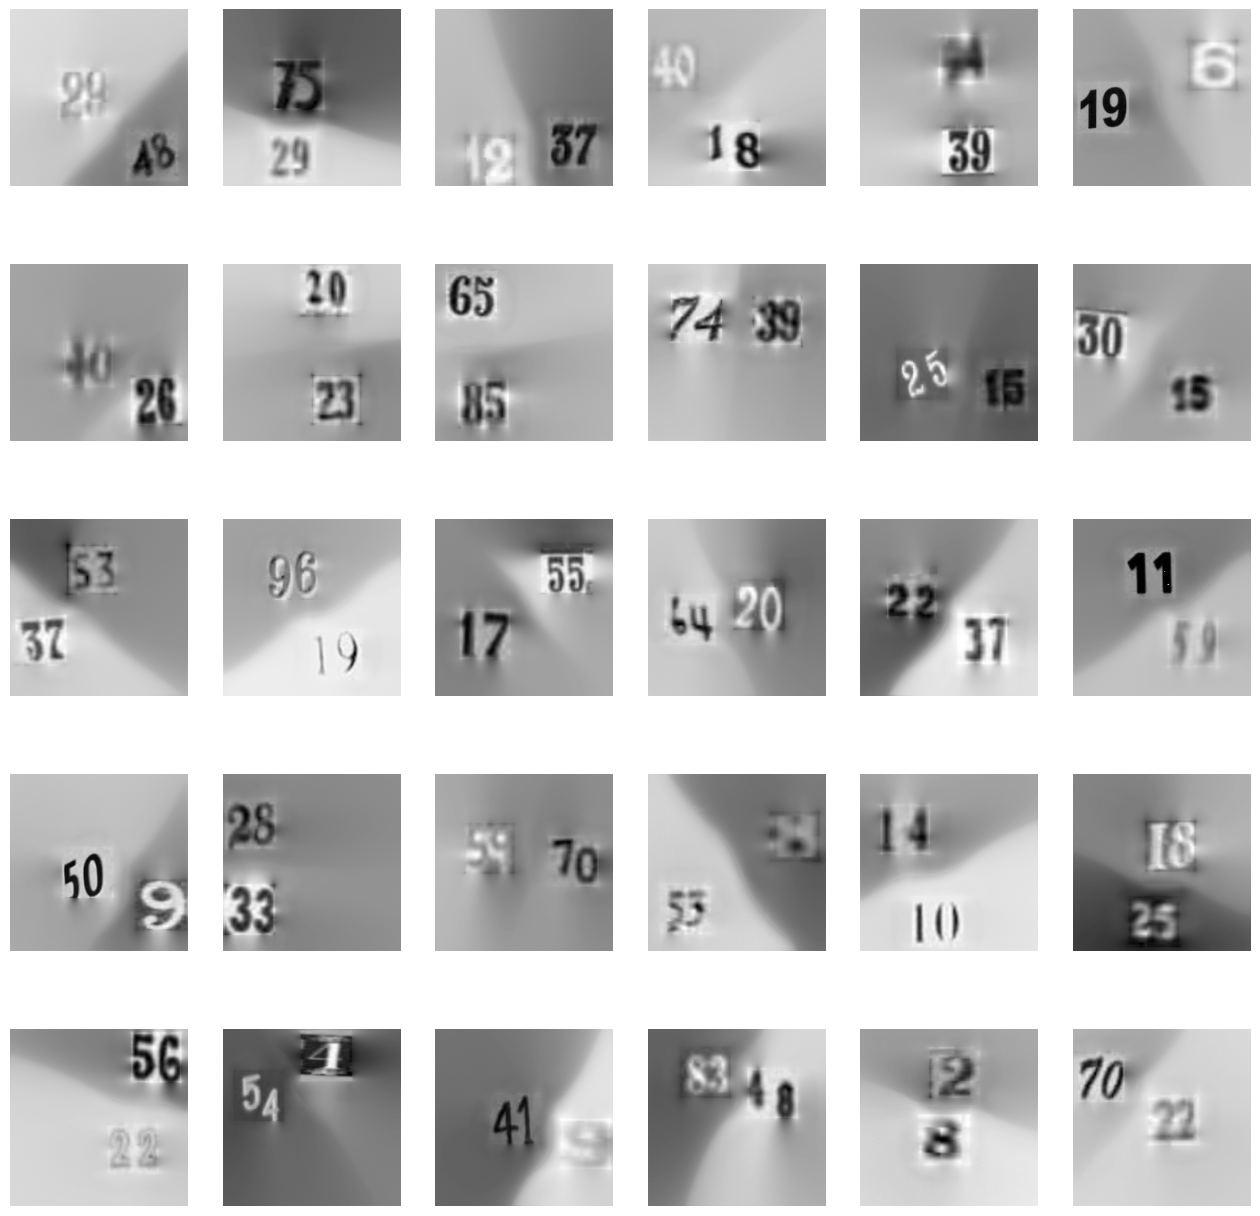

In [11]:
ncols, nrows = 6, 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16))


IMG_SIZE = 224
BBOX_SIZE = 64
NUM_NUMBERS = 2

rand_idx = np.random.randint(low=0, high=len(all_data), size=(NUM_NUMBERS, nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        # Initialize backgroud image
        new_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype="uint8")
        
        # to blur borders, we create a mask around the bbox to do inpainting
        mask = np.ones(new_img.shape, dtype="uint8")
        
        # POlygon object to keep track of numbers and avoid overlaping bboxes
        locs_union = Polygon()
        
        for k in range(NUM_NUMBERS):
            # get random sample
            sample = all_data[rand_idx[k, i, j]]
            
            # open image
            img_path = os.path.join(data_dir, sample["dataset_split"], sample["filename"])
            img = Image.open(img_path).convert('L')
            #w, h = img.size
            
            # get digit bboxes
            bboxes = sample["boxes"]

            # Get smaller bounding box that contain all digit bounding boxes
            x1 = int(min([i["left"] for i in bboxes]))
            y1 = int(min([i["top"] for i in bboxes]))
            x2 = int(max([i["left"] + i["width"] for i in bboxes]))
            y2 = int(max([i["top"] + i["height"] for i in bboxes]))
            
            # get matrix containing the bbox
            bbox_img = np.array(img)[y1:y2, x1:x2]
            bbox_img = (resize(bbox_img, (BBOX_SIZE, BBOX_SIZE)) * 256).astype("uint8")
            
            # compute the mean background color and create an empty background image with random noise
            mean_background_color = np.median(
                np.concatenate([bbox_img[:, 0], bbox_img[:, -1], bbox_img[0, :], bbox_img[-1, :]]))
            
            
            # invert colors if background dark
            if mean_background_color < 0.5*255:
                bbox_img = 255 - bbox_img
                mean_background_color = 255 - mean_background_color
            
            # randomly paste the bbox on the background image.
            # first, find 
            border = 10
            while True:
                # candidate position
                rand_x, rand_y = np.random.randint(0, IMG_SIZE-BBOX_SIZE), np.random.randint(0, IMG_SIZE-BBOX_SIZE)
                
                # test if the current position doesnt intersect with previous numbers
                poly_bbox = box(rand_x-border, rand_y-border, rand_x+BBOX_SIZE+border, rand_y+BBOX_SIZE+border)
                if poly_bbox.intersection(locs_union).area == 0:
                    # if there is no intersection, the position is valid
                    locs_union = locs_union.union(poly_bbox)
                    break
                
            new_img[rand_y:rand_y+BBOX_SIZE, rand_x:rand_x+BBOX_SIZE] = bbox_img
            
            # update inpainting mask
            mask[rand_y:rand_y+BBOX_SIZE, rand_x:rand_x+BBOX_SIZE] = 0
            
        new_img = cv2.inpaint(new_img, mask, 32, cv2.INPAINT_TELEA)
        
        # convert to PIL and resize image
        img = Image.fromarray(new_img)
        
        ax[i, j].axis("off")
        ax[i, j].imshow(img, cmap="gray")
        
plt.show()   

#### Visualize the different steps of the preprocessing method

In [13]:
current_sample = train_data[45]

# Define transforms
train_trans = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((64, 64)),
            transforms.RandomCrop((54, 54))])

# Read image
img_path = os.path.join(data_dir, current_sample["dataset_split"], current_sample["filename"])
img = Image.open(img_path)


w, h = img.size
bboxes = current_sample["boxes"]

img_boxes = img.copy()
img_draw = ImageDraw.Draw(img_boxes)
for box in bboxes:
    shape = [(box["left"], box["top"]), (box["left"]+box["width"], box["top"]+box["height"])]
    img_draw.rectangle(shape, outline ="green")

# Get smaller bounding box that contain all digit bounding boxes
x1 = min([i["left"] for i in bboxes])
y1 = min([i["top"] for i in bboxes])
x2 = max([i["left"] + i["width"] for i in bboxes])
y2 = max([i["top"] + i["height"] for i in bboxes])

img_draw.rectangle(((x1, y1), (x2, y2)), outline ="orange")

# Expand this bbox by 30% in both x and y axis
x1 = int(max(0, x1 - 0.15*(x2-x1)))
y1 = int(max(0, y1 - 0.15*(y2-y1)))
x2 = int(min(w, x2 + 0.15*(x2-x1)))
y2 = int(min(h, y2 + 0.15*(y2-y1)))

img_draw.rectangle(((x1, y1), (x2, y2)), outline ="red")

# Crop image
img_cropped = img.crop((x1, y1, x2, y2))


# Apply transforms (Resize + Normalize)
img_trans = train_trans(img_cropped)

# Get labels, we add an "end sequence" label (0) at the end
labels = [int(box["label"]) for box in current_sample["boxes"]] + [0]

# Max length is 5 (as in the paper)
labels = labels[:5]

TypeError: tuple indices must be integers or slices, not str

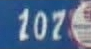

In [31]:
img

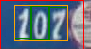

In [32]:
img_boxes

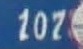

In [33]:
img_cropped

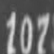

In [25]:
img_trans

#### Plot on the amount of samples per number of digits that appear in an image

In [8]:
# get number of digits per image in ALL the dataset
num_digits = []
for data in [train_data, val_data, test_data]:
    num_digits += [len(i["boxes"]) for i in data]

/tmp/ipykernel_2846592/3928420966.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None]+x.tolist())


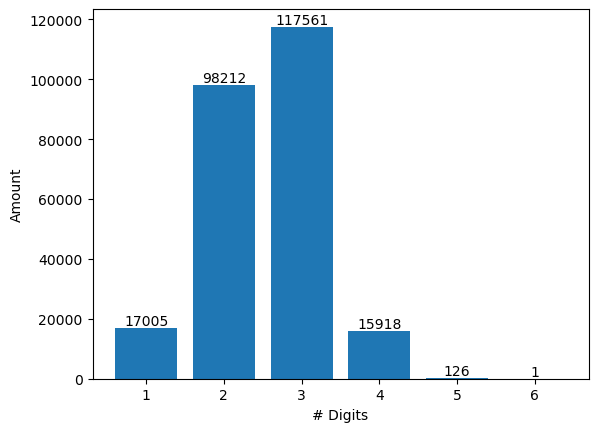

In [9]:
x, y = np.unique(num_digits, return_counts=True)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.bar(x, y)
ax.set_xlabel('# Digits')
ax.set_ylabel('Amount')
ax.set_xticklabels([None]+x.tolist())

# Make some labels.
labels = [f"{i}" for i in y]
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    );